### Project description:

In this notebook, we will explore two time series models to fit our current daily price data and make predictions based on our fitted models. The first method is **Auto-ARIMA** model, the second one is **SARIMAX** model. 

The advantage of the first model is that it can provide a stationary series using ADF test, the disadvantage is complicated data manipulation, for example: taking difference, cut-off partial series etc.

The advantage of the second mode is that it can deal with the original dataset and capture the trend and seasonality directly. **Statistical results show that the second model is more suitable to forecast the current dataset and can be easily generalized to a larger dataset.**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import statsmodels.api as sm
import pmdarima as pm


### Fist model: Auto-ARIMA model

In [2]:
class ARIMA_process:
    
    def __init__(self, data):
        self.series = data
        
    def adfuller_test(self, signif=0.05, name='', verbose=False):
        """Perform ADFuller to test for Stationarity of given series and print report"""
        r = adfuller(self.series, autolag='AIC')
        output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
        p_value = output['pvalue'] 
        def adjust(val, length= 6): return str(val).ljust(length)

        # Print Summary
        print(f' Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
        print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
        print(f' Significance Level    = {signif}')
        print(f' Test Statistic        = {output["test_statistic"]}')
        print(f' No. Lags Chosen       = {output["n_lags"]}')

        for key,val in r[4].items():
            print(f' Critical value {adjust(key)} = {round(val, 3)}')

        if p_value <= signif:
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")
        else:
            print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
            print(f" => Series is Non-Stationary.")    
    
    def plot_acf(self,lags =40):
        sm.graphics.tsa.plot_acf(self.series.values.squeeze(), lags=40)
        plt.show()
    
    def plot_pacf(self,lags =40):
        sm.graphics.tsa.plot_pacf(self.series.values.squeeze(), lags=40,color= 'gray')
        plt.show()             
              
    def auto_ARIMA(self,d=0,max_p=5, max_q=5, seasonal=False):
        self.model = pm.auto_arima(self.series.values, start_p=1, start_q=1,
                  test='adf',       # use adftest to find optimal 'd'
                  max_p=5, max_q=5, # maximum p and q
                  m=1,              # frequency of series
                  d = 0,           # the difference order is 1
                  seasonal=False,   # No Seasonality
                  D=0, 
                  trace=True,
                  error_action='ignore',  
                  suppress_warnings=True, 
                  stepwise=True)
        print(self.model.summary())             
        self.model.plot_diagnostics(figsize=(14,9))
        plt.show()
              
    
    def forecast(self):
        n_periods = self.series.shape[0]
        df = self.series
        df_test = self.series
              #self.series[-n_periods*0.3:]
        fc, confint = self.model.predict(n_periods=n_periods, return_conf_int=True)
        index_of_fc = df_test.index

        # make series for plotting purpose
        fc_series = pd.Series(fc, index=index_of_fc)
        lower_series = pd.Series(confint[:, 0], index=index_of_fc)
        upper_series = pd.Series(confint[:, 1], index=index_of_fc)

        def forecast_accuracy(forecast, actual):
            mae = np.mean(np.abs(forecast - actual))
            rmse = np.mean((forecast - actual)**2)**.5  # RMSE# MAE
            return  mae, rmse

        # compute MAE
        mae ,rmse = forecast_accuracy(fc_series, df_test) 
        print('Forecast Accuracy of Price using Auto_ARIMA: \n MAE =',round(mae,4))
        print('RMSE =', round(rmse,4))

        # Plot
        plt.figure(figsize=(8,4))
        plt.plot(df,'k',label ='data_difference')
        plt.plot(fc_series, 'darkgreen',label ='predicted values')
        plt.fill_between(lower_series.index, 
                         lower_series, 
                         upper_series, 
                         color='lightgreen', alpha=.15)
        plt.title("Forecast of default rate")
        plt.legend()  
        plt.show()

**Step1: Prepare the data as a time-series**

In [3]:
data = pd.read_csv('data.csv')

**Step2: Check for Stationarity and Make the Time Series Stationary**

In [4]:
arima = ARIMA_process(data['Data'])
arima.adfuller_test()

 Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9119
 No. Lags Chosen       = 0
 Critical value 1%     = -3.61
 Critical value 5%     = -2.939
 Critical value 10%    = -2.608
 => P-Value = 0.3265. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


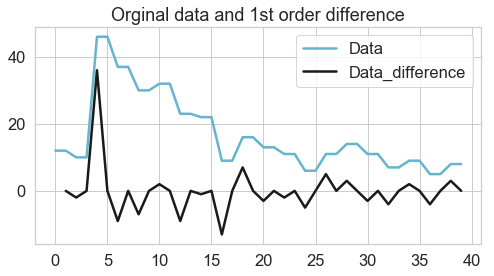

In [5]:
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
data['Data_difference'] = data.diff(periods = 1)
data.plot(title ='Orginal data and 1st order difference',figsize = (8,4),color = ['c', 'k'])
plt.show()

**Take the first order difference and check again:**

In [6]:
arima = ARIMA_process(data['Data_difference'][1:])
arima.adfuller_test()

 Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3572
 No. Lags Chosen       = 1
 Critical value 1%     = -3.621
 Critical value 5%     = -2.944
 Critical value 10%    = -2.61
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


Based on the ADF test, the differeniated PRICE time-series is **stationary**, then we can proceed ARIMA modeling.

**Step3: Using ARIMA model**

We will use ARIMA with dynamic regression approach, which is auto_ARIMA:
auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

Fit ARIMA: order=(1, 0, 1); AIC=265.940, BIC=272.594, Fit time=0.057 seconds
Fit ARIMA: order=(0, 0, 0); AIC=265.395, BIC=268.722, Fit time=0.002 seconds
Fit ARIMA: order=(1, 0, 0); AIC=267.395, BIC=272.385, Fit time=0.012 seconds
Fit ARIMA: order=(0, 0, 1); AIC=267.395, BIC=272.385, Fit time=0.008 seconds
Total fit time: 0.080 seconds
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   39
Model:                     ARMA(0, 0)   Log Likelihood                -130.697
Method:                           css   S.D. of innovations              6.905
Date:                Tue, 21 Jul 2020   AIC                            265.395
Time:                        17:17:43   BIC                            268.722
Sample:                             0   HQIC                           266.588
                                                                              
                 coef    std e

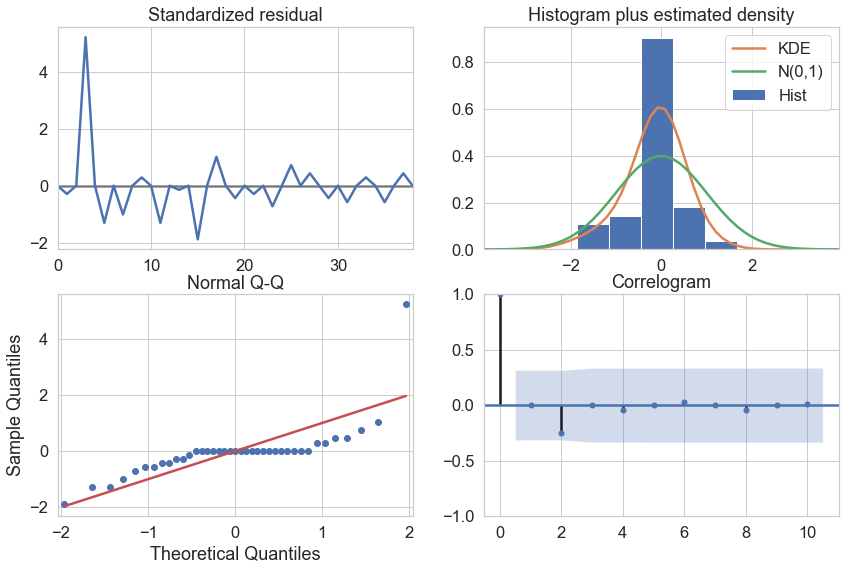

In [7]:
arima.auto_ARIMA()

**Plot interpretation:**

**Top left:** The residual errors(especially after point2) seem to fluctuate around a mean of zero and have a uniform variance.

**Top Right:** The density plot suggest normal distribution with mean zero.

**Bottom left:** All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed. Hence, this dataset has skewness.

**Bottom Right:** The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. 

Overall, it seems to be a good fit. Let’s forecast.

**Step4: Make forecast**

Forecast Accuracy of Price using Auto_ARIMA: 
 MAE = 3.1164
RMSE = 6.9052


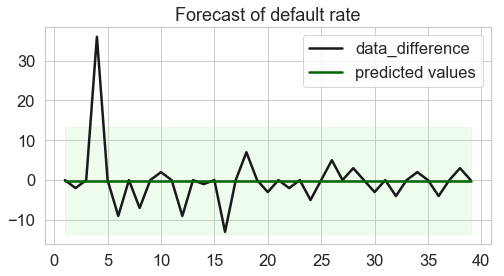

In [8]:
arima.forecast()

The prediected value in green line looks flattened and cannot be used for further predictions.

**Then we try to cut-off the first 5 points of the dataset and analyze it again:**

In [9]:
arima = ARIMA_process(data['Data_difference'][5:])
arima.adfuller_test()

 Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.2549
 No. Lags Chosen       = 9
 Critical value 1%     = -3.724
 Critical value 5%     = -2.986
 Critical value 10%    = -2.633
 => P-Value = 0.6495. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


ADF test shows that it is not stationary, hence we cannot proceed the following analysis. I decided to try another model which doesn't contian these complicated manipulations and directly capture the characteristic of the dataset:SARIMAX model.

### Second Model: SARIMAX model

In [10]:
dta_full = data['Data']
aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))
# aic_miss = pd.DataFrame(np.zeros((6,6), dtype=float))

warnings.simplefilter('ignore')

# Iterate over all ARMA(p,q) models with p,q in [0,6]
for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        # Estimate the model
        mod = sm.tsa.statespace.SARIMAX(dta_full, order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            aic_full.iloc[p,q] = res.aic
        except:
            aic_full.iloc[p,q] = np.nan
       

In [11]:
## check the AIC with different p,q combination 
aic_full

,0,1,2,3,4,5
0,0.000000,315.523631,301.001393,292.821225,289.925500,284.840394
1,272.259138,274.196920,273.817143,275.790744,277.476283,279.258650
2,274.227136,274.154448,275.768990,276.895417,278.878406,280.875883
3,274.116141,276.090383,277.206936,278.879295,280.873537,281.941677
4,276.106671,276.971707,278.896721,280.725795,282.795578,284.553500
5,277.491702,279.450955,280.891533,282.372359,283.889984,286.855395


In [12]:
# print out the statistical result 
mod = sm.tsa.statespace.SARIMAX(dta_full, order=(1,0,0))
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                   Data   No. Observations:                   40
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -134.130
Date:                Tue, 21 Jul 2020   AIC                            272.259
Time:                        17:17:46   BIC                            275.637
Sample:                             0   HQIC                           273.480
                                 - 40                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9282      0.079     11.717      0.000       0.773       1.083
sigma2        45.5661      3.627     12.565      0.000      38.458      52.674
Ljung-Box (Q):                         nan   Jarque-

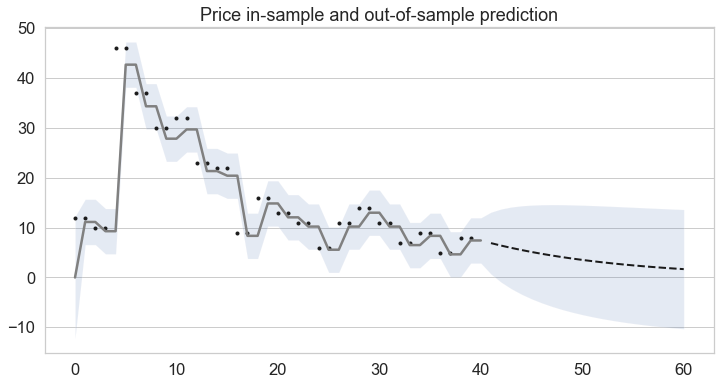

In [13]:
## make prediction for in-sample data and 20 out-of-sample data
nforecast = 20
predict = res.get_prediction(end=mod.nobs + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(dta_full, 'k.')

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'gray')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
ax.fill_between(idx, predict_ci['lower Data'], predict_ci['upper Data'], alpha=0.15)

ax.set(title='Price in-sample and out-of-sample prediction');

### Conclusion:

The predicted value looks reasonable and further prediction follows the decreasing momentum. 
In summary, **SARIMAX** model with p=1,q=0 is suitable for this dataset and can be extended to implement for a larger dataset.